# Show the disaggregator overview

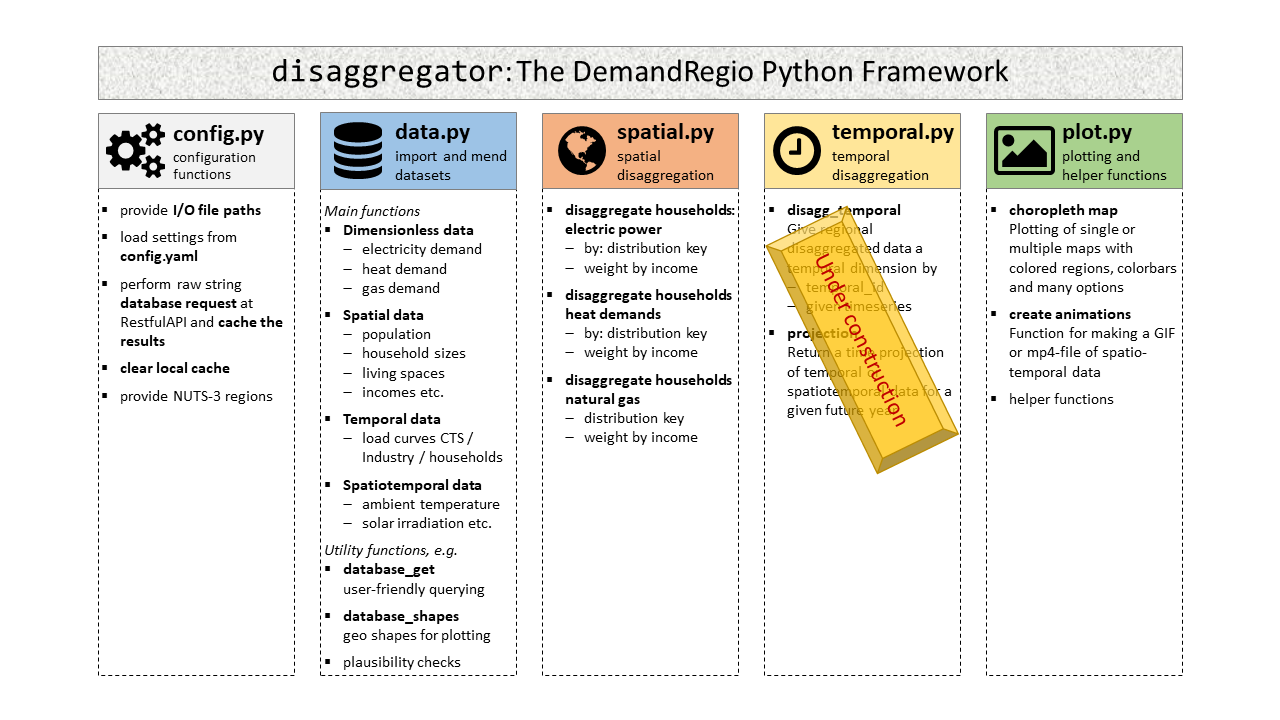

In [1]:
from IPython.display import Image
pic = Image(filename=('./img/overview.png'))
pic

# Spatial disaggregation with `spatial.py`

Now, as we've gathered a spatial feeling for the relevant input data in the first notebook, let's take a look at the spatial disaggregation abilities.

In [2]:
import pandas as pd
from disaggregator import config, data, spatial, plot

## Electric Power Consumption in [GWh/a]

The disaggregation method for the electric power consumption of private households is `spatial.disagg_households_power()` and requires at least one argument:

1. ``by`` is the distribution key and must be one of ``['population', 'households']``.  

    Using ``population`` invokes a *top-down*-method, i.e. the overall electricity consumption of entire Germany is being spread by distribution keys based on the population to calculate the consumption per region.  
    Using ``households`` invokes a *bottom-up*-method, i.e. the average electricity consumptions known for each household size are used for calculating the consumption per region.

Additionally, an income adjustment can be performed, through the switch ``weight_by_income=True``.

Let's start with ``population``:

In [3]:
ec_pop = spatial.disagg_households_power(by='population', weight_by_income=False)
ec_pop.head()

nuts3
DE111   1,001.919
DE112     612.457
DE113     841.913
DE114     405.994
DE115     857.891
Name: value, dtype: float64

... and continue with ``households``:

In [4]:
ec_hh = spatial.disagg_households_power(by='households', weight_by_income=False)
ec_hh.head()

hh_size,1,2,3,4,5,6
nuts3,,,,,,
DE111,265.798,320.806,167.560,136.285,56.557,27.865
DE112,105.046,186.141,111.730,109.856,42.512,17.918
DE113,157.170,266.055,152.146,145.414,53.125,22.166
DE114,67.260,124.215,75.795,72.368,27.966,11.999
DE115,157.152,279.344,150.432,148.467,53.767,22.565


So, do these two fundamentally different methods lead to comparable results? Let's check, by summing the consumptions of all six household types per region:

In [5]:
ec_hh.head().sum(axis=1)

nuts3
DE111   974.870
DE112   573.202
DE113   796.076
DE114   379.604
DE115   811.727
dtype: float64

Okay, that seems comparable.  
Let's further check the results by plotting these side by side on *one* map. We can achieve this, by merging the results into one new ``pd.DataFrame`` :

In [6]:
ec_combined = pd.concat([ec_pop, ec_hh.sum(axis=1)], keys=['population', 'households'], axis=1, join='inner')
ec_combined.head()

,population,households
nuts3,,
DE111,"1,001.919",974.870
DE112,612.457,573.202
DE113,841.913,796.076
DE114,405.994,379.604
DE115,857.891,811.727


... and plot:

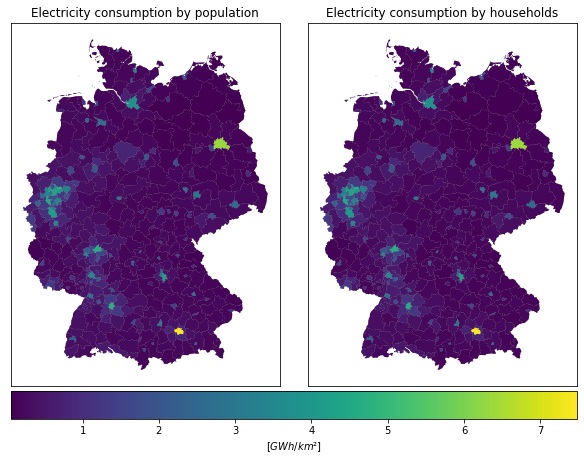

In [7]:
fig, ax = plot.choropleth_map(ec_combined, relative=True, unit='GWh', axtitle='Electricity consumption by', add_percentages=False)

Now let's weight the consumptions by the available income:

In [8]:
ec_pop_ic = spatial.disagg_households_power(by='population', weight_by_income=True)
ec_hh_ic = spatial.disagg_households_power(by='households', weight_by_income=True)
ec_combined = pd.concat([ec_pop, ec_hh.sum(axis=1), ec_pop_ic, ec_hh_ic.sum(axis=1)],
                        keys=['population', 'households', 'population (weighted)', 'households (weighted)'],
                        axis=1, join='inner')

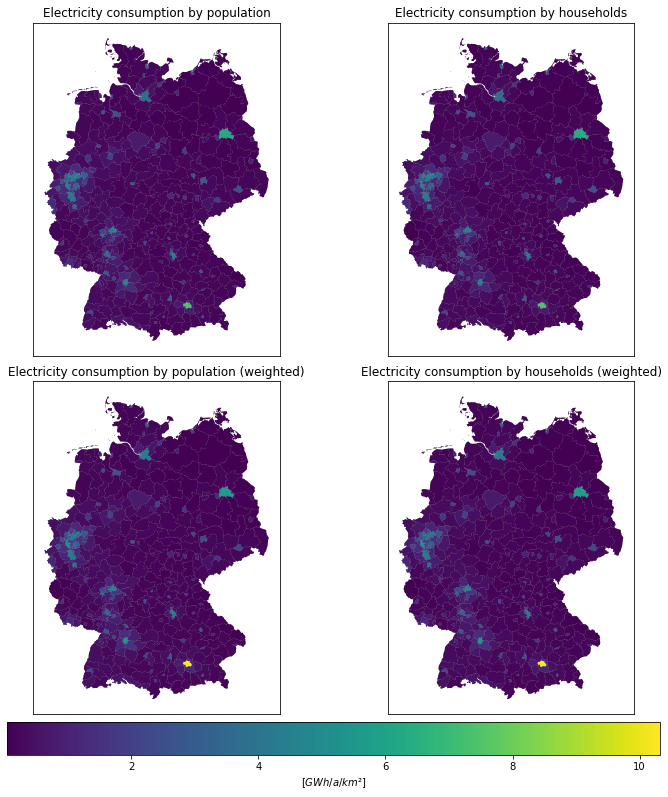

In [9]:
fig, ax = plot.choropleth_map(ec_combined, relative=True, unit='GWh/a', axtitle='Electricity consumption by',
                              add_percentages=False, figsize=(10,12))

Now save this figure e.g. as PDF file:

In [10]:
from disaggregator.config import _data_out
fig.savefig(_data_out('disagg_households_power.pdf'), bbox_inches='tight')

## Heat consumption in [MWh/a]

The heating demands of private households are threefold:
1. cooking (=process heat)
2. warm water
3. space heating

The first two ones depend mainly on the **household size**, whereas the latter depends mainly on the **size of the building**. However, centralized space heating systems are very often also used as boilers for the hot water supply.

In [11]:
df_heat = spatial.disagg_households_heat(by='households')
df_heat.head()

Application           Cooking                                             \
PersonsInHousehold      1.000      2.000      3.000      4.000     5.000   
nuts3                                                                      
DE111              27,268.362 36,737.712 16,683.920 16,521.960 5,656.665   
DE112              10,776.744 21,316.284 11,124.960 13,317.885 4,251.870   
DE113              16,124.130 30,467.844 15,149.200 17,628.660 5,313.350   
DE114               6,900.300 14,224.716  7,546.880  8,773.275 2,797.095   
DE115              16,122.348 31,989.672 14,978.480 17,998.750 5,377.610   

Application                    HotWater                                   \
PersonsInHousehold     6.000      1.000      2.000      3.000      4.000   
nuts3                                                                      
DE111              2,786.980 55,087.600 74,217.600 45,501.600 44,428.800   
DE112              1,792.140 21,771.200 43,063.200 30,340.800 35,812.800   
DE113              2,216.970 32,574.000 61,551.200 41,316.000 47,404.800   
DE114              1,200.115 13,940.000 28,736.800 20,582.400 23,592.000   
DE115              2,256.835 32,570.400 64,625.600 40,850.400 48,400.000   

Application                               
PersonsInHousehold      5.000      6.000  
nuts3                                     
DE111              19,014.000 11,241.600  
DE112              14,292.000  7,228.800  
DE113              17,860.000  8,942.400  
DE114               9,402.000  4,840.800  
DE115              18,076.000  9,103.200

In [12]:
df_heat_bld = spatial.disagg_households_heat(by='buildings')
df_heat_bld.head()

Application  SpaceHeatingOnly                                            \
BuildingType              1FH           2FH     MFH_03_06     MFH_07_12   
nuts3                                                                     
DE111             915,737.578   530,841.696 2,028,863.941 1,758,676.648   
DE112           1,748,241.359   857,255.262   915,982.986   610,061.289   
DE113           2,250,065.737 1,133,649.823 1,515,593.862   814,341.149   
DE114           1,246,221.943   744,385.579   619,206.983   278,186.040   
DE115           2,300,993.647 1,092,595.276 1,473,324.545   893,215.447   

Application              SpaceHeatingPlusHotWater                              \
BuildingType   MFH_13_99                      1FH           2FH     MFH_03_06   
nuts3                                                                           
DE111        920,471.266            1,037,409.005   601,373.113 2,298,433.281   
DE112        390,106.568            1,980,525.176   971,156.315 1,037,687.022   
DE113        372,639.362            2,549,025.521 1,284,274.629 1,716,966.477   
DE114        122,474.398            1,411,803.880   843,289.960   701,479.241   
DE115        410,066.869            2,606,720.076 1,237,765.283 1,669,080.957   

Application                               
BuildingType     MFH_07_12     MFH_13_99  
nuts3                                     
DE111        1,992,346.977 1,042,771.646  
DE112          691,118.385   441,938.910  
DE113          922,540.324   422,150.886  
DE114          315,147.822   138,747.220  
DE115        1,011,894.425   464,551.280

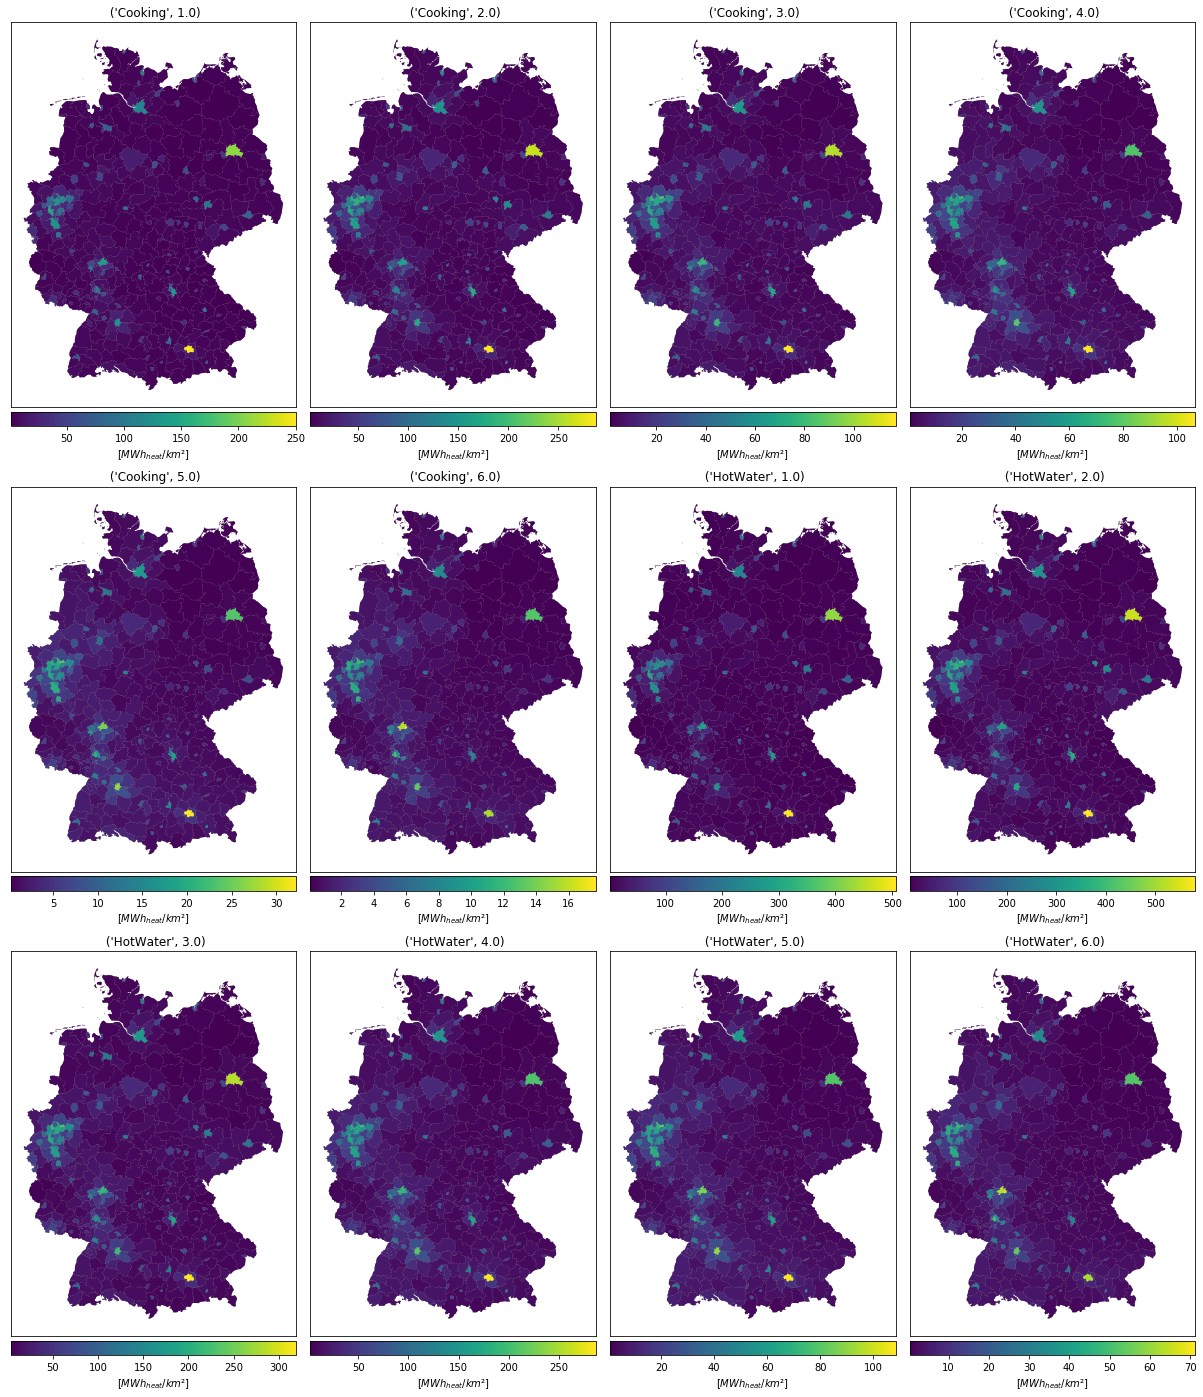

In [13]:
fig, ax = plot.choropleth_map(df_heat, unit='MWh_{heat}', colorbar_each_subplot=True, add_percentages=False)

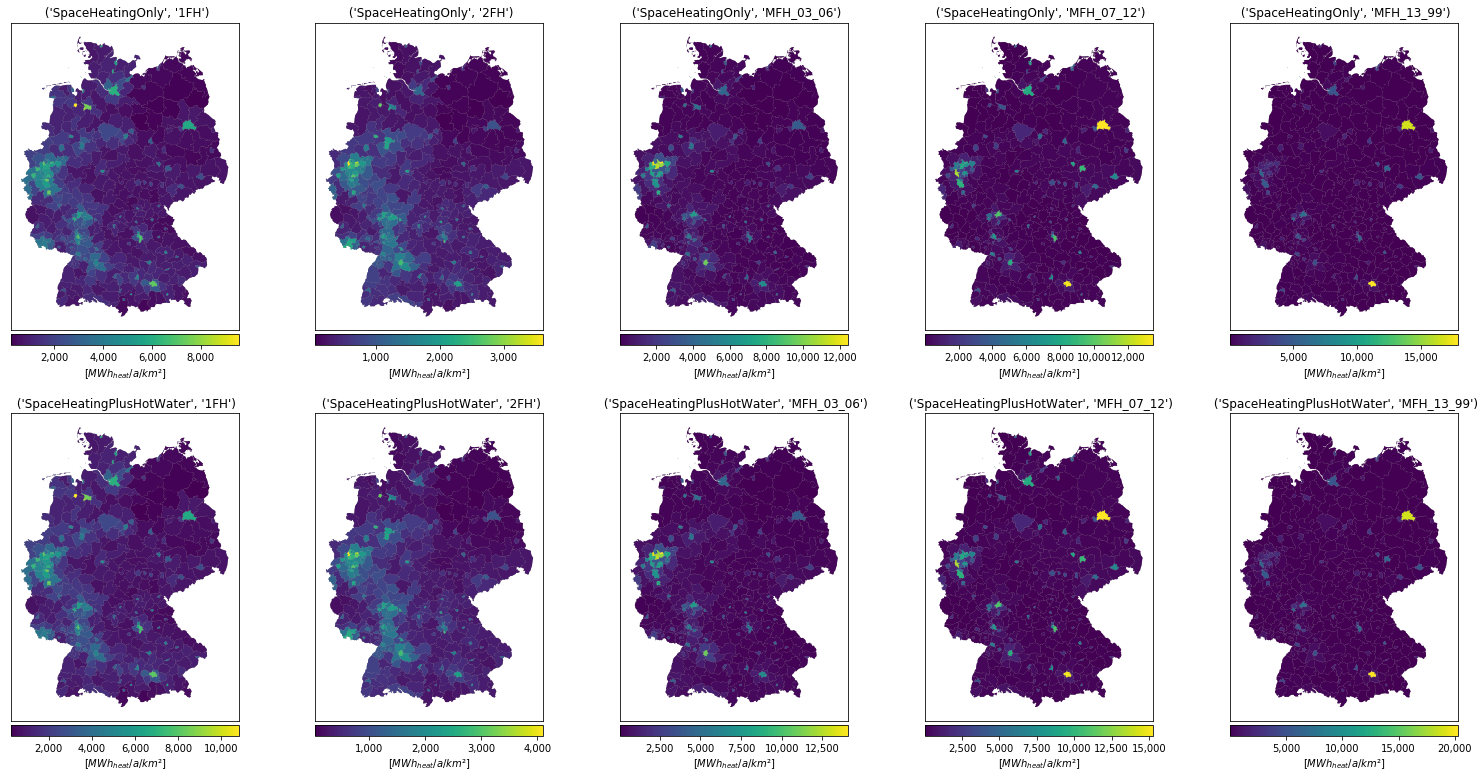

In [14]:
fig, ax = plot.choropleth_map(df_heat_bld, unit='MWh_{heat}/a', colorbar_each_subplot=True, add_percentages=False, figsize=(21, 11))

## Gas Consumption in [MWh/a]

In [15]:
df_gas = spatial.disagg_households_gas()
df_gas.head()

disaggregator.spatial: INFO     Calculating regional gas demands top-down.


,Cooking,HotWater,SpaceHeating
nuts3,,,
DE111,"8,521.563","359,475.412","990,576.816"
DE112,"4,560.001","192,360.022","707,913.430"
DE113,"6,454.651","272,284.371","961,452.912"
DE114,"3,003.337","126,693.401","509,579.728"
DE115,"6,571.148","277,198.712","1,025,283.878"


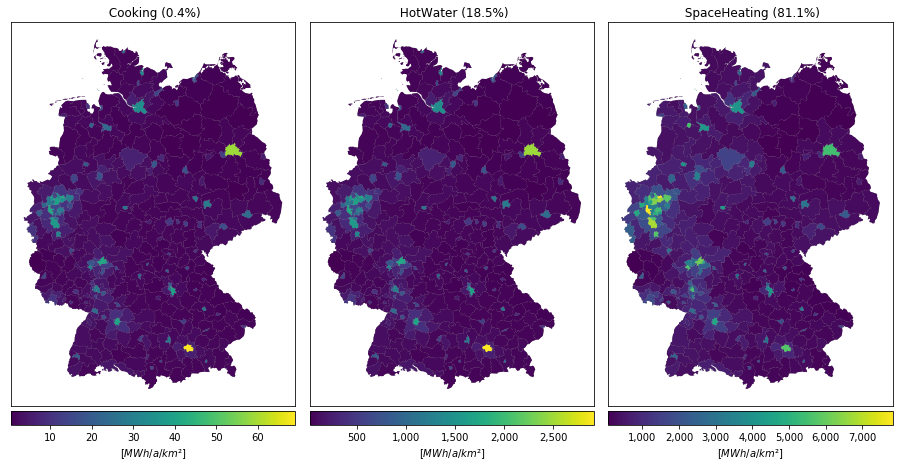

In [16]:
fig, ax = plot.choropleth_map(df_gas, unit='MWh/a', relative=True, colorbar_each_subplot=True)